In [5]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects


2023-05-31 00:47:49.498405: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jcampos/miniforge3/lib/:/home/jcampos/miniforge3/lib/
2023-05-31 00:47:49.498427: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
import sys 
sys.path.append("..")

import hls4ml
import numpy as np
from sklearn.metrics import accuracy_score 
import matplotlib.pyplot as plt


In [3]:
from utils.config import print_dict

In [4]:
X_test = np.load('../data/all/X_train_val.npy')
y_train_val = np.load('../data/all/y_train_val.npy')
y_test = np.load('../data/all/y_test.npy', allow_pickle=True)

In [5]:
# Load keras Model #1 predictions for each time slice 
y_keras_slice1 = np.genfromtxt('y_keras_slice1.dat', dtype=np.float32, delimiter=' ')  # (1000, 3)
y_keras_slice2 = np.genfromtxt('y_keras_slice2.dat', dtype=np.float32, delimiter=' ')
y_keras_slice3 = np.genfromtxt('y_keras_slice3.dat', dtype=np.float32, delimiter=' ')
y_keras_slice4 = np.genfromtxt('y_keras_slice4.dat', dtype=np.float32, delimiter=' ')
y_keras_slice5 = np.genfromtxt('y_keras_slice5.dat', dtype=np.float32, delimiter=' ')

# Combine each time slice into single array 
X_test = np.concatenate((y_keras_slice1, y_keras_slice2, y_keras_slice3, y_keras_slice4, y_keras_slice5), axis=1)
X_test.shape  # (1000, 15)

# Save concatenated array 
np.savetxt(f'keras_inputs.dat', X_test, fmt='%.10f')

In [6]:
# Load hls Model #1 predictions for each time slice 
y_hls_slice1 = np.genfromtxt('y_hls_slice1.dat', dtype=np.float32, delimiter=' ')  # (1000, 3)
y_hls_slice2 = np.genfromtxt('y_hls_slice2.dat', dtype=np.float32, delimiter=' ')
y_hls_slice3 = np.genfromtxt('y_hls_slice3.dat', dtype=np.float32, delimiter=' ')
y_hls_slice4 = np.genfromtxt('y_hls_slice4.dat', dtype=np.float32, delimiter=' ')
y_hls_slice5 = np.genfromtxt('y_hls_slice5.dat', dtype=np.float32, delimiter=' ')

# Combine each time slice into single array 
x_hls_inputs = np.concatenate((y_hls_slice1, y_hls_slice2, y_hls_slice3, y_hls_slice4, y_hls_slice5), axis=1)
x_hls_inputs.shape  # (1000, 15)

# Save concatenated array 
np.savetxt(f'hls_inputs.dat', x_hls_inputs, fmt='%.10f')


In [7]:
co = {} 
_add_supported_quantized_objects(co)
model = load_model('model_2_b16_i6_ex2_v3.h5', custom_objects=co, compile=False)

keras_pred = model.predict(X_test)
print(model.summary()) 

# Compute accuracy with ground truth and keras predictions 
model_acc = accuracy_score(np.argmax(keras_pred, axis=1), y_test) 
print(f'Model Accuracy: {model_acc}')

2023-05-31 00:47:07.071379: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jcampos/miniforge3/lib/:/home/jcampos/miniforge3/lib/
2023-05-31 00:47:07.071433: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-31 00:47:07.071480: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (correlator3.fnal.gov): /proc/driver/nvidia/version does not exist
2023-05-31 00:47:07.071972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


32/32 [==============================] - 0s 2ms/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (QDense)             (None, 15)                240       
                                                                 
 relu1 (QActivation)         (None, 15)                0         
                                                                 
 layer2 (QDense)             (None, 2)                 32        
                                                                 
 softmax (Activation)        (None, 2)                 0         
                                                                 
Total params: 272
Trainable params: 272
Non-trainable params: 0
_________________________________________________________________
None
Model Accuracy: 0.71


In [8]:
HLSConfig = {}
HLSConfig['Model'] = {}
HLSConfig['Model']['Precision'] = 'ap_fixed<16,6>'
HLSConfig['Model']['ReuseFactor'] = 1

HLSConfig['LayerName'] = {}
for layer in ['layer1_input', 'layer1', 'relu1', 'relu2', 'layer2', 'layer1_linear', 'layer2_linear', 'softmax']:
    HLSConfig['LayerName'][layer] = {}
    HLSConfig['LayerName'][layer]['Precision'] = {}
    HLSConfig['LayerName'][layer]['Trace'] = True

HLSConfig['LayerName']['layer1_input']['Precision'] = 'ap_fixed<16,6>'

### LAYER 1 ###
HLSConfig['LayerName']['layer1']['Precision']['result'] = 'ap_fixed<16,10>'
HLSConfig['LayerName']['layer1']['accum_t'] = 'ap_fixed<16,10>'
HLSConfig['LayerName']['layer1_linear']['Precision']['result'] = 'ap_fixed<16,10>'

### LAYER 2 ###
HLSConfig['LayerName']['layer2']['Precision']['result'] = 'ap_fixed<16,6>'
HLSConfig['LayerName']['layer2']['accum_t'] = 'ap_fixed<16,6>'
HLSConfig['LayerName']['layer2_linear']['Precision']['result'] = 'ap_fixed<16,6>'

### ACTIVATIONS ###
HLSConfig['LayerName']['relu1']['Precision']['result'] = 'ap_ufixed<16,6,AP_RND,AP_SAT>'

print_dict(HLSConfig)

Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
LayerName
  layer1_input
    Precision:       ap_fixed<16,6>
    Trace:           True
  layer1
    Precision
      result:        ap_fixed<16,10>
    Trace:           True
    accum_t:         ap_fixed<16,10>
  relu1
    Precision
      result:        ap_ufixed<16,6,AP_RND,AP_SAT>
    Trace:           True
  relu2
    Precision
    Trace:           True
  layer2
    Precision
      result:        ap_fixed<16,6>
    Trace:           True
    accum_t:         ap_fixed<16,6>
  layer1_linear
    Precision
      result:        ap_fixed<16,10>
    Trace:           True
  layer2_linear
    Precision
      result:        ap_fixed<16,6>
    Trace:           True
  softmax
    Precision
    Trace:           True


In [9]:
OutputDir = 'hls4ml_prj_qkeras_model2/'
XilinxPart = 'xczu49dr-ffvf1760-2-e'
IOType = 'io_parallel'
ClockPeriod = 5
HLSFig = OutputDir+'model.png'

hls_model = hls4ml.converters.convert_from_keras_model(
    model=model,
    hls_config=HLSConfig,
    output_dir=OutputDir,
    part=XilinxPart,
    io_type=IOType,
    clock_period=ClockPeriod,
    # backend='VivadoAccelerator',
    # interface='axi_master',
    # driver='c',
    # board='zcu216',
)

print(f"Creating hls4ml project directory {OutputDir}")
hls_model.compile()

# Visualize model
hls4ml.utils.plot_model(
    hls_model, show_shapes=True, show_precision=True, to_file=HLSFig
)

Interpreting Sequential
Topology:
Layer name: layer1_input, layer type: InputLayer, input shapes: [[None, 15]], output shape: [None, 15]
Layer name: layer1, layer type: QDense, input shapes: [[None, 15]], output shape: [None, 15]
Layer name: relu1, layer type: Activation, input shapes: [[None, 15]], output shape: [None, 15]
Layer name: layer2, layer type: QDense, input shapes: [[None, 15]], output shape: [None, 2]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 2]], output shape: [None, 2]
Creating HLS model
Creating hls4ml project directory hls4ml_prj_qkeras_model2/
Writing HLS project


Done


In [10]:
hls_pred = hls_model.predict(np.ascontiguousarray(x_hls_inputs)) 
_, hls_trace = hls_model.trace(np.ascontiguousarray(X_test)) 

Recompiling myproject with tracing
Writing HLS project


Done


In [11]:
# Save inputs from keras and hls models 
np.savetxt('model2_tb/keras_inputs.dat', X_test, fmt='%.10f')
np.savetxt('model2_tb/hls_inputs.dat', x_hls_inputs, fmt='%.10f')

# Save predictions from keras and hls models 
np.savetxt('model2_tb/y_keras_predictions.dat', keras_pred, fmt='%.10f')
np.savetxt('model2_tb/y_hls_predictions.dat', hls_pred, fmt='%.10f')

# Save ground truth
np.savetxt('model2_tb/y_test.dat', y_test, fmt='%i')

In [12]:
# Compute accuracy (y_true, y_pred) = (keras_pred, hls_pred)
print(f'y_hls shape: {hls_pred.shape}')
print(f'y_pred shape: {keras_pred.shape}')

acc = accuracy_score(np.argmax(keras_pred, axis=1), np.argmax(keras_pred, axis=1)) 
print(f'Accuracy (how well keras and hls match): {acc}\n')

# Compute accuracy (y_true, y_pred) = (ground_truth, hls_pred)
print(f'y_hls shape: {hls_pred.shape}')
print(f'y_pred shape: {y_test.shape}')
final_acc = accuracy_score(y_test, np.argmax(hls_pred, axis=1)) 
print(f'Final Model Accuracy {final_acc}')

y_hls shape: (1000, 2)
y_pred shape: (1000, 2)
Accuracy (how well keras and hls match): 1.0

y_hls shape: (1000, 2)
y_pred shape: (1000,)
Final Model Accuracy 0.713


In [13]:
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test) 

Processing layer1 in Keras model...
32/32 [==============================] - 0s 619us/step
Processing relu1 in Keras model...
32/32 [==============================] - 0s 667us/step
Processing layer2 in Keras model...
32/32 [==============================] - 0s 729us/step
Processing softmax in Keras model...
32/32 [==============================] - 0s 801us/step
Done taking outputs for Keras model.


layer1 		 0.124844305
hls/keras min: -8.78125/-8.650279998779297
hls/keras max: 7.15625/7.30102014541626


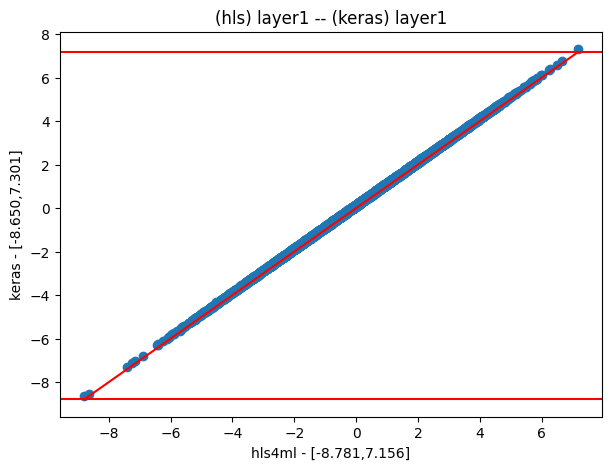

relu1 		 0.064550325
hls/keras min: 0.0/0.0
hls/keras max: 7.15625/7.30078125


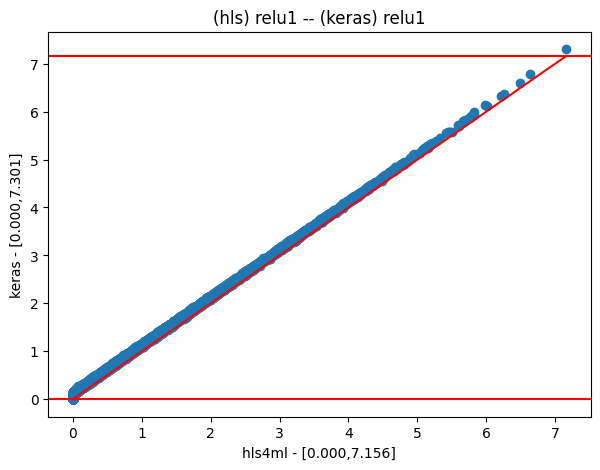

layer2 		 0.2068211
hls/keras min: -13.3203125/-13.699048042297363
hls/keras max: 11.978515625/12.348068237304688


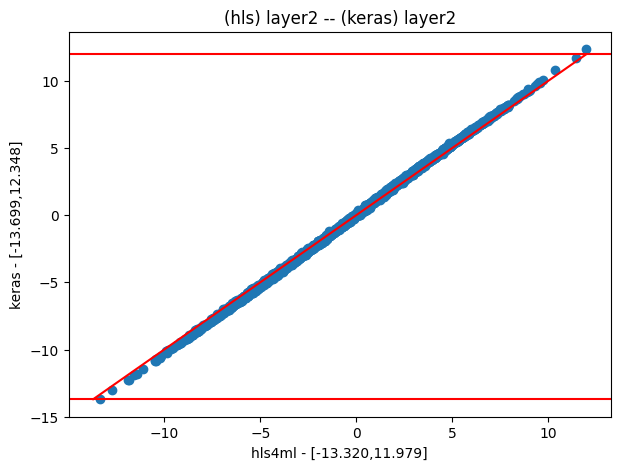

softmax 		 0.018337563
hls/keras min: -0.2099609375/9.237998387090496e-12
hls/keras max: 1.37890625/0.9999999403953552


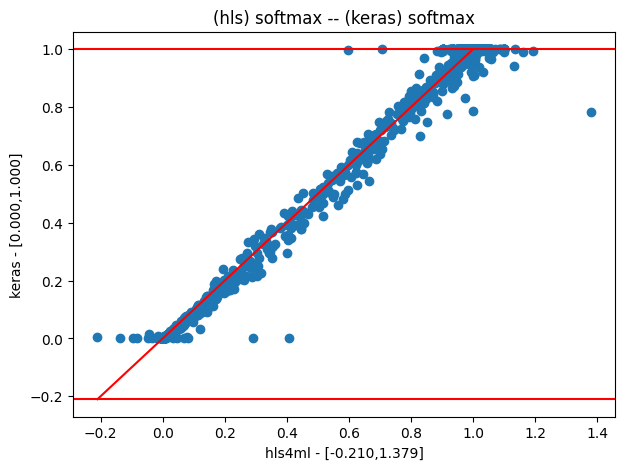

In [14]:
layers = ['layer1', 'relu1', 'layer2', 'softmax']

for idx, layer in enumerate(layers):
    keras_layer, hls_layer = keras_trace[layer], hls_trace[layer]
    try:
        diff = np.average(np.abs(keras_layer - hls_layer ))
        print(f'{layer}', '\t\t', diff)
        
        plt.figure(figsize=(7, 5))

        plt.scatter(hls_layer.flatten(), keras_layer.flatten())
        min_x = min(keras_layer.min(), hls_layer.min())
        max_x = min(keras_layer.max(), hls_layer.max())

        onnx_min, onnx_max = keras_layer.flatten().min(), keras_layer.flatten().max()
        hls_min, hls_max = hls_layer.flatten().min(), hls_layer.flatten().max()
        
        print(f'hls/keras min: {hls_min}/{onnx_min}')
        print(f'hls/keras max: {hls_max}/{onnx_max}')
        
        plt.plot([min_x, max_x], [min_x, max_x], c='red')
        plt.axhline(min_x, c='red')
        plt.axhline(max_x, c='red')
        # plt.plot([min_x, max_x], [min_x, max_x], c='red')

        plt.title(f'(hls) {layer} -- (keras) {layer}')
        plt.xlabel(f'hls4ml - [{hls_min:.3f},{hls_max:.3f}]')
        plt.ylabel(f'keras - [{onnx_min:.3f},{onnx_max:.3f}]')
        plt.show()
        
        plt.savefig(f'../results/{idx}_(hls){layer} -- (keras){layer}.png')
        plt.close()

    except Exception as e:
        print(e)


### Visualizing Keras and HLS inputs (Output of Model #1)

In [15]:
%matplotlib widget

In [7]:
hls_data = np.genfromtxt('hls_inputs.dat', dtype=np.float32, delimiter=' ')
keras_data = np.genfromtxt('keras_inputs.dat', dtype=np.float32, delimiter=' ')

assert hls_data.shape == keras_data.shape

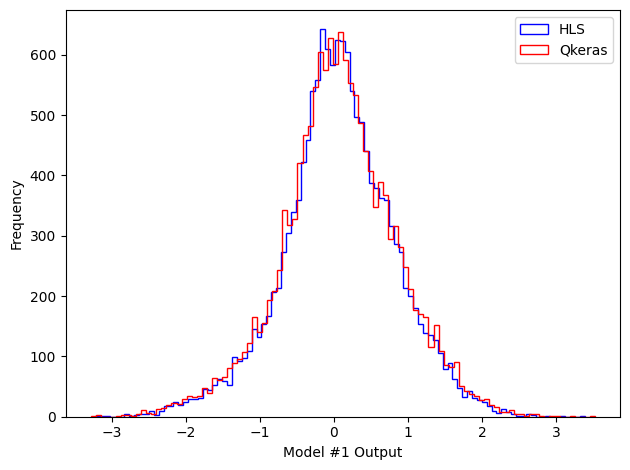

In [8]:
num_bins = 100

plt.figure()

_ = plt.hist(hls_data.reshape(-1), bins=num_bins, histtype='step', label='HLS', color='blue')
_ = plt.hist(keras_data.reshape(-1), bins=num_bins, histtype='step', label='Qkeras', color='red')

plt.legend()
plt.xlabel('Model #1 Output')
plt.ylabel('Frequency')
plt.tight_layout()

In [9]:
hls_data = hls_data.reshape(-1, 5, 3)
keras_data = keras_data.reshape(-1, 5, 3)

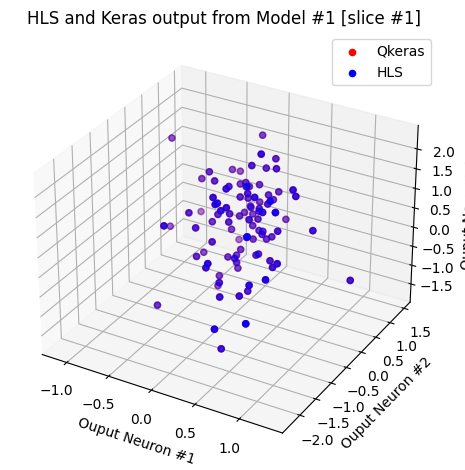

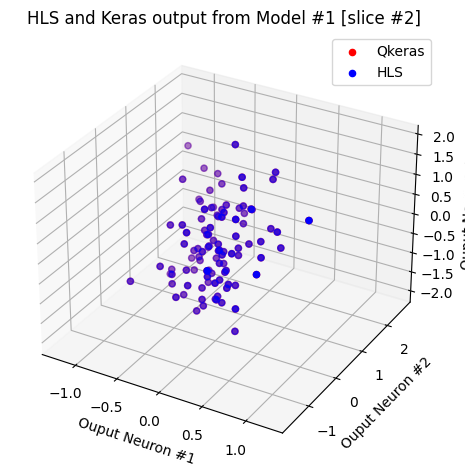

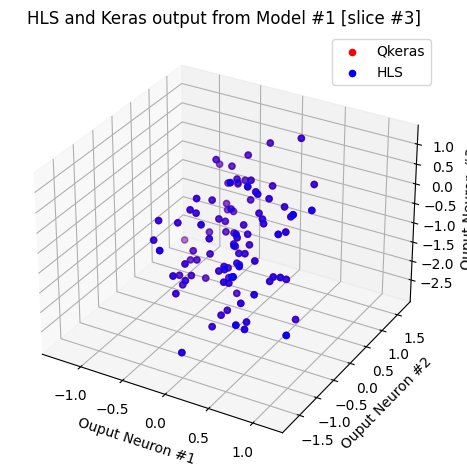

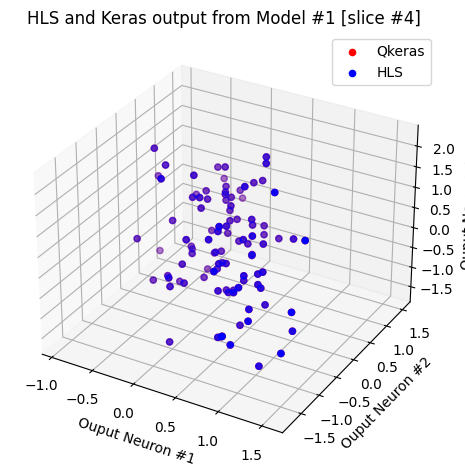

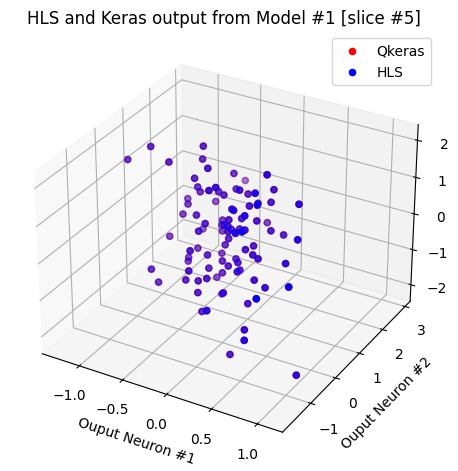

In [11]:
# Plot hls and qkeras output for each time slice in scatter plots

num_data_points = 100  # Set to -1 to use entire test set 

for slice_index in range(5):
    hls_slice_output = hls_data[:num_data_points,slice_index,:]
    keras_slice_output = hls_data[:num_data_points,slice_index,:]

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(keras_slice_output[:,0], keras_slice_output[:,1], keras_slice_output[:,2], c='red', label='Qkeras')
    ax.scatter(hls_slice_output[:,0], hls_slice_output[:,1], hls_slice_output[:,2], c='blue', label='HLS')

    ax.set_title(f'HLS and Keras output from Model #1 [slice #{slice_index+1}]')
    ax.set_xlabel('Ouput Neuron #1')
    ax.set_ylabel('Ouput Neuron #2')
    ax.set_zlabel('Ouput Neuron #3')
    ax.legend()
    plt.tight_layout()
    plt.show()